In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('tam_cleaned.txt', encoding='utf-8').read().strip().split('\n')    

    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [4]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'tam', True)
print(random.choice(pairs))

Reading lines...
Read 201 sentence pairs
Counting words...
Counted words:
tam 564
eng 433
['நான் எதிர் காலத்தில் ஒரு விமானியாக விரும்புகிறேன்', 'i want to be a pilot in the future.']


In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [6]:
MAX_LENGTH = 30 # maximum length is 10 words 

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [7]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [9]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [10]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [13]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [15]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 300, print_every=5, plot_every=5)

Reading lines...
Read 201 sentence pairs
Counting words...
Counted words:
fra 564
eng 433
0m 2s (- 2m 32s) (5 1%) 1.8147
0m 4s (- 2m 2s) (10 3%) 1.0000
0m 6s (- 2m 5s) (15 5%) 0.9037
0m 8s (- 2m 1s) (20 6%) 0.8298
0m 11s (- 2m 1s) (25 8%) 0.7684
0m 12s (- 1m 56s) (30 10%) 0.7051
0m 14s (- 1m 51s) (35 11%) 0.6416
0m 16s (- 1m 48s) (40 13%) 0.5754
0m 18s (- 1m 45s) (45 15%) 0.5117
0m 20s (- 1m 41s) (50 16%) 0.4549
0m 22s (- 1m 38s) (55 18%) 0.4048
0m 23s (- 1m 35s) (60 20%) 0.3612
0m 25s (- 1m 32s) (65 21%) 0.3220
0m 27s (- 1m 29s) (70 23%) 0.2876
0m 29s (- 1m 27s) (75 25%) 0.2603
0m 31s (- 1m 25s) (80 26%) 0.2314
0m 33s (- 1m 25s) (85 28%) 0.2106
0m 36s (- 1m 24s) (90 30%) 0.1888
0m 38s (- 1m 22s) (95 31%) 0.1689
0m 40s (- 1m 20s) (100 33%) 0.1488
0m 42s (- 1m 18s) (105 35%) 0.1304
0m 44s (- 1m 16s) (110 36%) 0.1148
0m 46s (- 1m 14s) (115 38%) 0.0996
0m 48s (- 1m 12s) (120 40%) 0.0859
0m 50s (- 1m 10s) (125 41%) 0.0730
0m 52s (- 1m 8s) (130 43%) 0.0624
0m 54s (- 1m 6s) (135 45%) 0.0529


In [16]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> நான் இப்பொழுது போக வேண்டும்
= i have to go now.
< i have to go now. <EOS>

> அவள் எதற்கும் பயப்படுவதில்லை
= she is not afraid of anything.
< she is not afraid of anything. anything. anything. <EOS>

> நிறைய மக்கள் நான் பைத்தியம் என்று எண்ணுகிறார்கள்
= most people think i'm crazy.
< most people use that word anymore. <EOS>

> உன்னிடம் நிறைய பேனாக்கள் இருக்கின்றனவா?
= do you have a lot of pens?
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> எங்களை உதவி செய்யும்படி கேட்டான்
= he asked us to help him.
< he asked us were silent. <EOS>

> நான் ஒரு விதமான மகிழ்ச்சியிலிருக்கிறேன்
= i'm kind of happy.
< i'm kind of shoes. <EOS>

> அந்த பக்கம்தான் வழி
= that's the way.
< i wonder why tom suggested we do i thought you'd be angry. glanced through this. i swallow. swallow. swallow. swallow. <EOS>

> அவர் உங்களுடைய நண்பரா?
= is he a friend of yours?
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SO

In [17]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('அவள் பாட ஆரம்பித்தாள்')

# evaluateAndShowAttention('அந்த பையன் அழ ஆரம்பித்தான்')

# evaluateAndShowAttention('அவன் ஏரியில் நீச்சலடித்தான்')

evaluateAndShowAttention('அவள் அன்பானவள்')


# evaluateAndShowAttention('அவள் அவனைக் கடித்தாள்')

input = அவள் பாட ஆரம்பித்தாள்
output = where i slept. him. books. he began began began sing. together. him. <EOS>
input = அவள் அன்பானவள்
output = she smiled. him. <EOS>


/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/2562436826.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/2562436826.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/2562436826.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/2562436826.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000g

input = அவள் பாட ஆரம்பித்தாள்
output = where i slept. him. books. he began began began sing. together. him. <EOS>


/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Glyph 2997 

<Figure size 640x480 with 0 Axes>

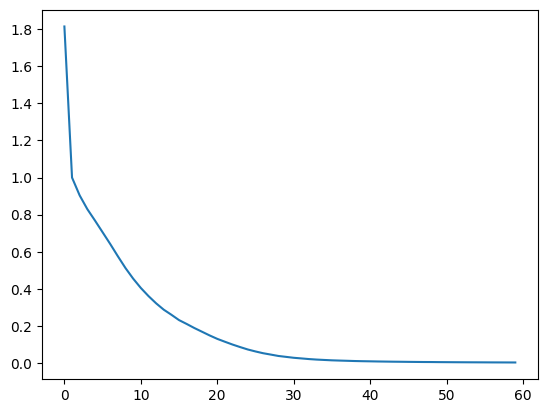

/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2997 (\N{TAMIL LETTER VA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2995 (\N{TAMIL LETTER LLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython

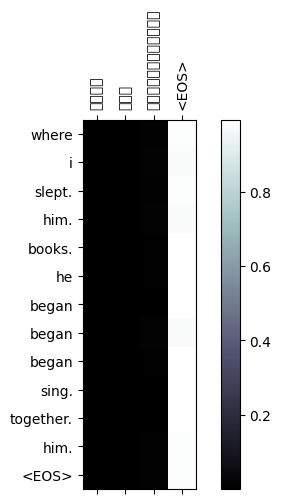

/Users/navaneethmalingan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2985 (\N{TAMIL LETTER NNNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


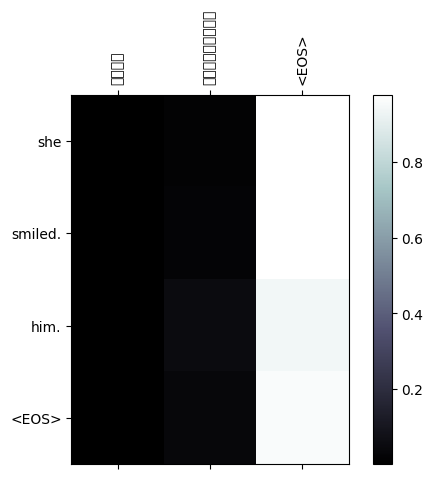

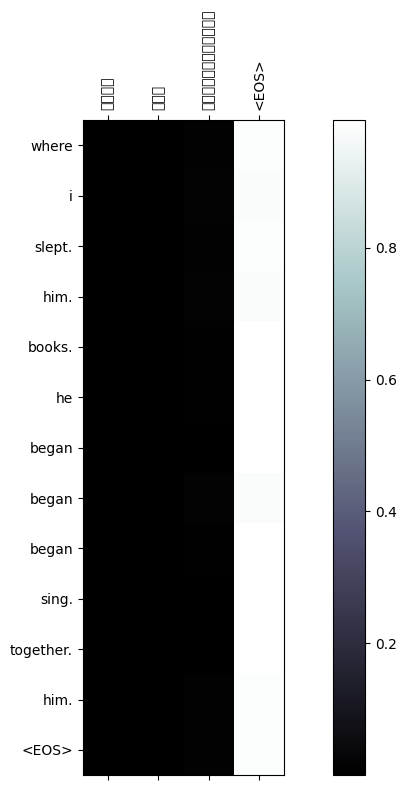

input = அவள் அன்பானவள்
output = she smiled. him. <EOS>


/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
/var/folders/5p/1ncbfs612_z26t8m9d2j0rlr0000gn/T/ipykernel_42315/202907914.py:23: UserWarning: Glyph 2997 

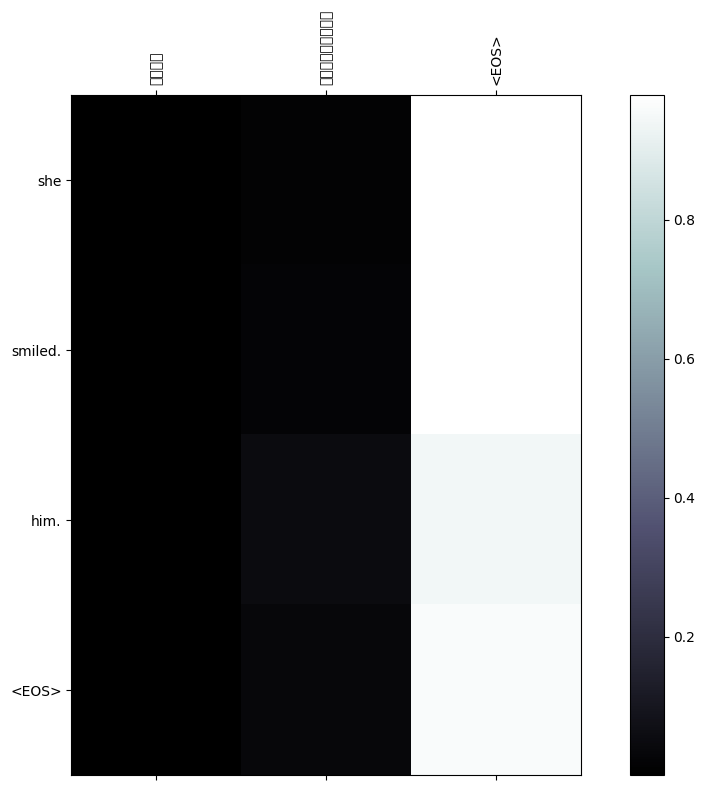

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    attention = attentions.cpu().numpy()
    cax = ax.matshow(attention, cmap='bone')
    
    # Add colorbar
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.tight_layout()
    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

# Test the function
evaluateAndShowAttention('அவள் பாட ஆரம்பித்தாள்')
evaluateAndShowAttention('அவள் அன்பானவள்')


In [19]:
# pass all the input sentences in the dataset and print original and predicted. append into a dataframe
import pandas as pd

data = []
for pair in pairs:
    output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    data.append({'input': pair[0], 'original': pair[1], 'predicted': output_sentence})

df = pd.DataFrame(data)
# do not truncate the dataframe height
pd.set_option('display.max_rows', None) 
df.head(100)


ModuleNotFoundError: No module named 'pandas'

In [54]:
# predict for new sentences

inputs = ["அவள் பாட ஆரம்பித்தாள்", "அவள் அன்பானவள்", "அவள் அவனைக் கடித்தாள்", "அவள் கொடுத்தாள்", "அவள் யார் என்று பார்"]
for input in inputs:
    output_words, _ = evaluate(encoder, decoder, input, input_lang, output_lang)
    print(output_words)


['she', 'began', 'to', 'sing.', '<EOS>']
['she', 'is', 'kind.', '<EOS>']
['she', 'bit', 'him.', '<EOS>']
['she', 'gave', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS']
['do', 'you', 'plan', 'to', 'do?', '<EOS>']
